In [ ]:
# Dataset:
    # Simulated engine degradation under different combinations of operational conditions and modes 
    # Records several sensor channels to characterize fault evolution. Provided by NASA
    # https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/
# Approach:
    # Prognostics: predicting the time at which something will no longer perform it's indended function
    # Remaining Useful Life (RUL): continious target, number of useful cycles left on the engine
    # Last 15 Cycles: binary target, represents whether the asset is in the last 15 cycles of life
    # This approach predicts 'RUL' and 'Last 15 Cycles' by treating each time point independently
    # A next step is to spend time feature engineering
    # A next step would be to use LSTM or another time series appropriate deep learning approach

In [12]:
# load necessary packages and view available data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import keras
%matplotlib inline
sns.set()
#print(os.listdir("../input"))
# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [13]:
# the files did not contain headers. Here we create labels based on documentation
target_var = ['Target_Remaining_Useful_Life']
index_columns_names =  ["UnitNumber","Cycle"]
op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
column_names = index_columns_names + op_settings_columns + sensor_columns
print(column_names)

['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3', 'Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_6', 'Sensor_7', 'Sensor_8', 'Sensor_9', 'Sensor_10', 'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16', 'Sensor_17', 'Sensor_18', 'Sensor_19', 'Sensor_20', 'Sensor_21']


In [16]:
# load data
train= pd.read_csv('train_FD001.txt', sep=" ", header=None)
test = pd.read_csv('test_FD001.txt', sep=" ", header=None)
print("train shape: ", train.shape, "test shape: ", test.shape)
# drop pesky NULL columns
train.drop(train.columns[[26, 27]], axis=1, inplace=True)
test.drop(test.columns[[26, 27]], axis=1, inplace=True)
# name columns
train.columns = column_names
test.columns = column_names
train[train['UnitNumber'] == 1].head(5)
test[test['UnitNumber'] == 1].head(5)

train shape:  (20631, 28) test shape:  (13096, 28)


,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [17]:
train.columns

Index(['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3',
       'Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_6',
       'Sensor_7', 'Sensor_8', 'Sensor_9', 'Sensor_10', 'Sensor_11',
       'Sensor_12', 'Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16',
       'Sensor_17', 'Sensor_18', 'Sensor_19', 'Sensor_20', 'Sensor_21'],
      dtype='object')

In [19]:
# this section calculates Remaining Useful Life (RUL) in T-minus notation for the training data
# find the last cycle per unit number
max_cycle = train.groupby('UnitNumber')['Cycle'].max().reset_index()
max_cycle

,UnitNumber,Cycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


In [20]:
max_cycle.columns = ['UnitNumber', 'MaxOfCycle']

In [21]:
# merge the max cycle back into the original frame
train_merged = train.merge(max_cycle, left_on='UnitNumber', right_on='UnitNumber', how='inner')

In [22]:
# calculate RUL for each row
Target_Remaining_Useful_Life = train_merged["MaxOfCycle"] - train_merged["Cycle"]
train_with_target = train_merged["Target_Remaining_Useful_Life"] = Target_Remaining_Useful_Life

In [23]:
# remove unnecessary column
train_with_target = train_merged.drop("MaxOfCycle", axis=1)
train_with_target[train_with_target['UnitNumber'] == 1].head(5)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Target_Remaining_Useful_Life
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1264: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


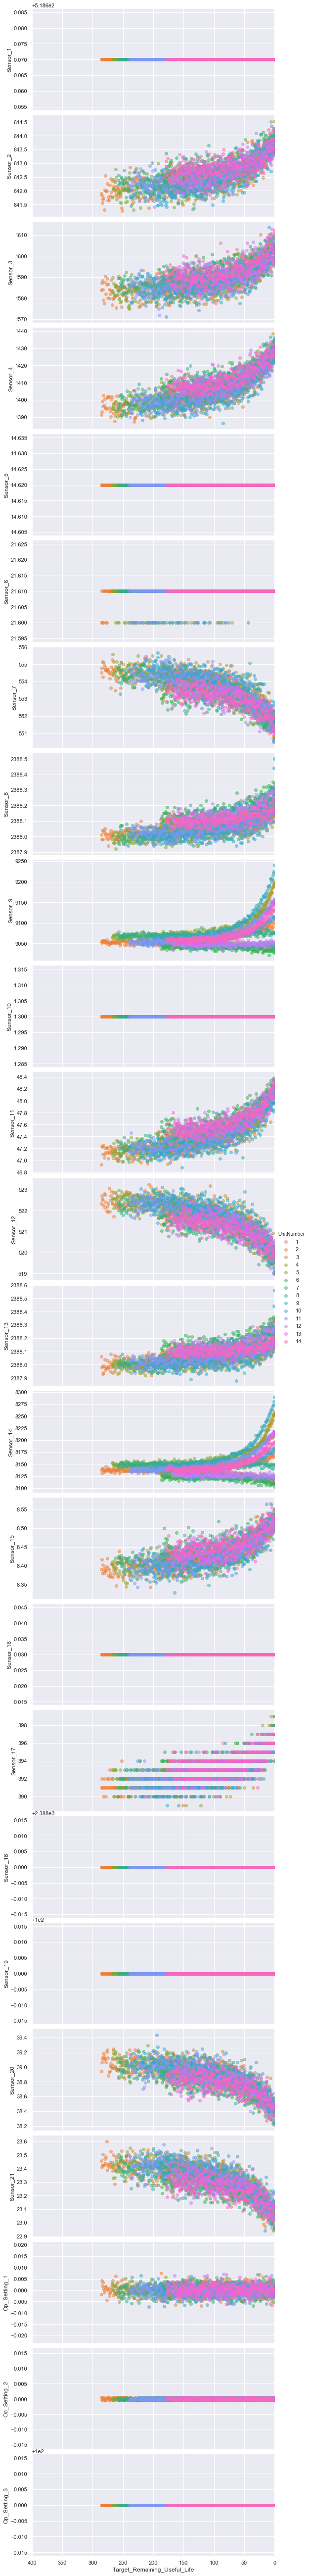

In [24]:
# use seaborn to visualize featuresto target (RUL)
explore = sns.PairGrid(data=train_with_target.query('UnitNumber < 15') ,
                 x_vars=target_var,
                 y_vars=sensor_columns + op_settings_columns,
                 hue="UnitNumber", size=3, aspect=2.5)
explore = explore.map(plt.scatter, alpha=0.5)
explore = explore.set(xlim=(400,0))
explore = explore.add_legend()

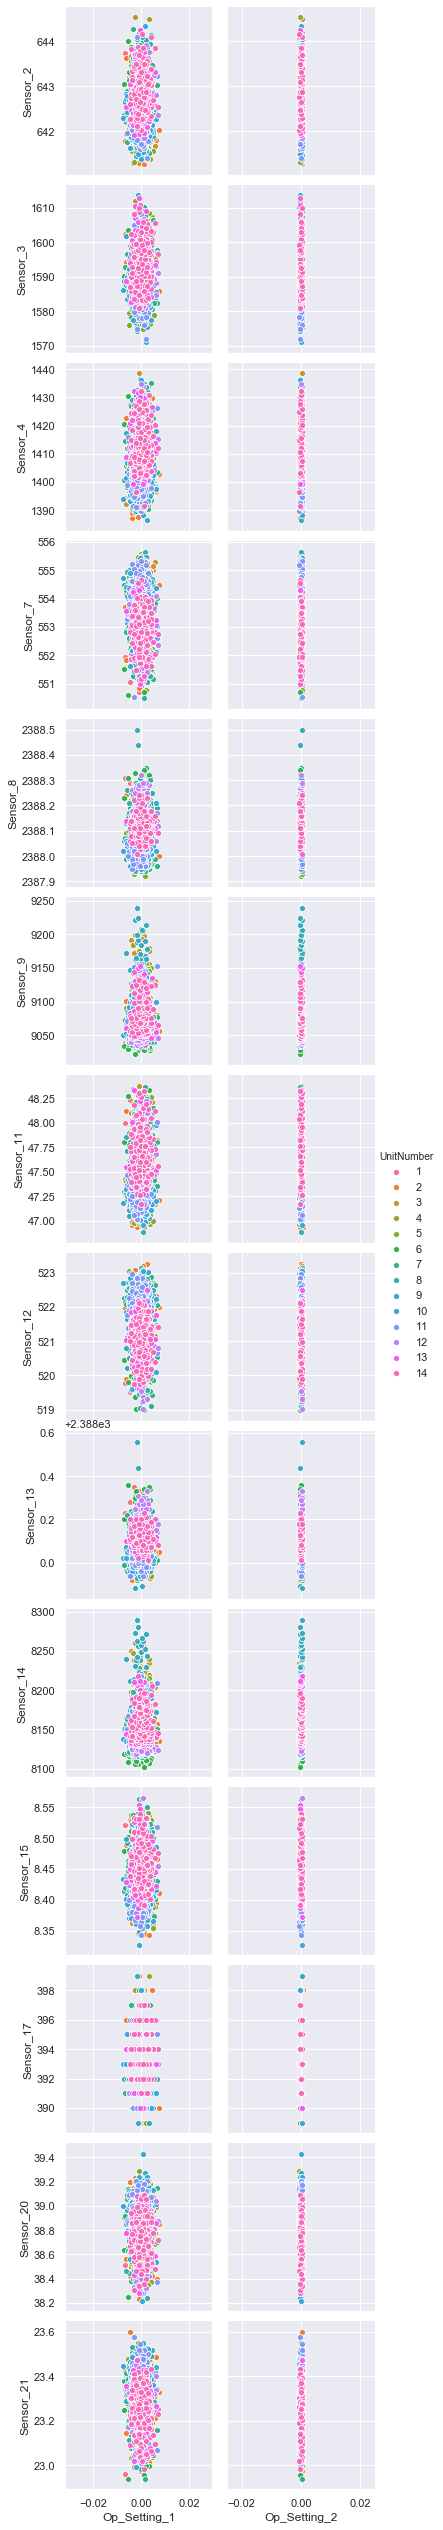

In [25]:
# operational setting 3 is stable, let's visualize op setting 1 and 2 against some of the most active sensors
g = sns.pairplot(data=train_with_target.query('UnitNumber < 15'),
                 x_vars=["Op_Setting_1","Op_Setting_2"],
                 y_vars=["Sensor_2", "Sensor_3", "Sensor_4", "Sensor_7", "Sensor_8", "Sensor_9", "Sensor_11", "Sensor_12", "Sensor_13", "Sensor_14", "Sensor_15", "Sensor_17", "Sensor_20", "Sensor_21"],
                 hue="UnitNumber", aspect=1)

In [26]:
# now it's time to clear out target leakage
print(train_with_target.shape)
leakage_to_drop = ['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3']  
train_no_leakage = train_with_target.drop(leakage_to_drop, axis = 1)
print(train_no_leakage.shape)
# set up features and target variable 
y = train_no_leakage['Target_Remaining_Useful_Life']
X = train_no_leakage.drop(['Target_Remaining_Useful_Life'], axis = 1)

(20631, 27)
(20631, 22)


In [27]:
# I like to use a simple random forest to determine some of the most important/meaningful features. Can be used as feature selection
# create an exhuastive random forest (200 trees up to 15 levels deep)
from sklearn import ensemble
rf = ensemble.RandomForestRegressor()
single_rf = ensemble.RandomForestRegressor(n_estimators = 200, max_depth = 15)
single_rf.fit(X, y)
y_pred = single_rf.predict(X)
print("complete")

complete


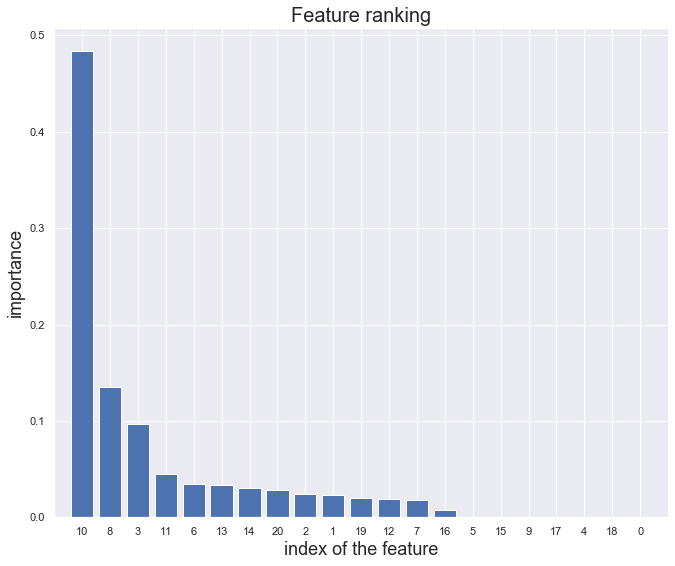

Sensor_11    0.483372
Sensor_9     0.135095
Sensor_4     0.097162
Sensor_12    0.044909
Sensor_7     0.034436
Sensor_14    0.033587
Sensor_15    0.030271
Sensor_21    0.027977
Sensor_3     0.024597
Sensor_2     0.023624
dtype: float64


In [28]:
# graph feature importance
import matplotlib.pyplot as plt
importances = single_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns    
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X.shape[1]), indices) #feature_names, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()
# list feature importance
important_features = pd.Series(data=single_rf.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features.head(10))

In [29]:
# based on the graphs as well as random forest feature importance, I will exclude sensors without much valuable information
print(train_no_leakage.shape)
vars_to_drop = ["Sensor_"+str(i) for i in [5, 15, 9, 17, 4, 18]]
train_final = train_no_leakage.drop(vars_to_drop, axis = 1)
print(train_final.shape)

(20631, 22)
(20631, 16)


In [30]:
# identify categorical and numeric fields
from sklearn import preprocessing
categorical = train_final.select_dtypes(include=['object'])
numeric = train_final.select_dtypes(exclude=['object'])
print(categorical.columns.values)
# create dummy variables (if any categorical fields)
for name, values in categorical.items():
    print(name)
    dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
    numeric = pd.concat([numeric, dummies], axis=1)
# imputation (if any NULL values)
for name in numeric:
    print(name)
    if pd.isnull(numeric[name]).sum() > 0:
        numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
        median = numeric[name].median()
        numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)
y = numeric['Target_Remaining_Useful_Life']
X = numeric.drop(['Target_Remaining_Useful_Life'], axis = 1)

[]
Sensor_1
Sensor_2
Sensor_3
Sensor_6
Sensor_7
Sensor_8
Sensor_10
Sensor_11
Sensor_12
Sensor_13
Sensor_14
Sensor_16
Sensor_19
Sensor_20
Sensor_21
Target_Remaining_Useful_Life


In [31]:
# random forest regression
# create holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn.ensemble import RandomForestRegressor
rf = ensemble.RandomForestRegressor()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# tune the model
my_min_samples_leaf = [2, 10, 25, 50, 100]
my_max_depth = [7, 8, 9, 10, 11, 12]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)
# show the best model estimators
print(optimized_rf.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = optimized_rf.predict(X_test)
print("Random Forest Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Random Forest Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Random Forest r-squared: ", r2_score(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.9min finished


Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=11,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=10, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)
Random Forest Mean Squared Error:  1768.024101

In [ ]:
# Elastic Net GLM
# create holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn.linear_model import ElasticNet
glm_net = ElasticNet()

# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', glm_net) ])
# tune the model
my_alpha = np.linspace(.01, 1, num=5)
my_l1_ratio = np.linspace(.01, 1, num=3)
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_glm_net = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__l1_ratio = my_l1_ratio, model__alpha = my_alpha)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_glm_net.fit(X_train, y_train)
# show the best model estimators
print(optimized_glm_net.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = optimized_glm_net.predict(X_test)
print("GLM Elastic Net Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("GLM Elastic Net Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("GLM Elastic Net r-squared: ", r2_score(y_test, y_pred))

In [ ]:
# Support Vector Machines
# create holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn import svm
from sklearn.svm import SVR
svm = svm.SVR()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', svm) ])
# tune the model
my_C = [1]
my_epsilon = [.05, .1, .15]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_svm = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__C = my_C, model__epsilon = my_epsilon)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_svm.fit(X_train, y_train)
# show the best model estimators
print(optimized_svm.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = optimized_svm.predict(X_test)
print("SVM Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("SVM Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("SVM r-squared: ", r2_score(y_test, y_pred))

In [ ]:
# Gradient Boosting
# create holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn.ensemble import GradientBoostingRegressor
gb = ensemble.GradientBoostingRegressor()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', gb) ])
# tune the model
my_alpha = [.5, .75, .9]
my_n_estimators= [500]
my_learning_rate = [0.005, .01]
my_max_depth = [4, 5, 6]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_gb = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__max_depth = my_max_depth, model__n_estimators = my_n_estimators,
                                              model__learning_rate = my_learning_rate, model__alpha = my_alpha)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_gb.fit(X_train, y_train)
# show the best model estimators
print(optimized_gb.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = optimized_gb.predict(X_test)
print("Gradient Boosting Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Gradient Boosting Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Gradient Boosting r-squared: ", r2_score(y_test, y_pred))

In [ ]:
# plot actual vs predicted Remaining Useful Life for the best model (GBM)
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual RUL')
ax.set_ylabel('Predicted RUL')
ax.set_title('Remaining Useful Life Actual vs. Predicted')
plt.show()

In [ ]:
# now let's look at turning this into a classification sol -> can we confidently identify when an asset within its last 15 cycles?
# generate label columns for training data
cycles = 15
train_no_leakage['Target_15_Cycles'] = np.where(train_no_leakage['Target_Remaining_Useful_Life'] <= cycles, 1, 0 )
train_no_leakage.tail(5)

In [ ]:
# based on the graphs as well as random forest feature importance, I will exclude sensors without much valuable information
print(train_no_leakage.shape)
vars_to_drop = ["Sensor_"+str(i) for i in [5, 15, 9, 17, 4, 18]]
target_to_drop = ['Target_Remaining_Useful_Life']
train_final = train_no_leakage.drop(vars_to_drop, axis = 1)
train_final = train_no_leakage.drop(target_to_drop, axis = 1)
train_final.tail()

In [ ]:
# identify categorical and numeric fields
from sklearn import preprocessing
categorical = train_final.select_dtypes(include=['object'])
numeric = train_final.select_dtypes(exclude=['object'])
print(categorical.columns.values)
# create dummy variables (if any categorical fields)
for name, values in categorical.items():
    print(name)
    dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
    numeric = pd.concat([numeric, dummies], axis=1)
# imputation (if any NULL values)
for name in numeric:
    print(name)
    if pd.isnull(numeric[name]).sum() > 0:
        numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
        median = numeric[name].median()
        numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)
y = numeric['Target_15_Cycles']
X = numeric.drop(['Target_15_Cycles'], axis = 1)

In [ ]:
# random forest regression
# create holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
rf = ensemble.RandomForestClassifier()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# tune the model
my_min_samples_leaf = [2, 25, 50]
my_max_depth = [8, 9, 10, 12]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)
# show the best model estimators
y_pred_proba = optimized_rf.predict_proba(X_test)[:, 1]
y_pred = optimized_rf.predict(X_test)
print(optimized_rf.best_estimator_)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
from sklearn.metrics import classification_report
print("Random Forest Accuracy: "+"{:.1%}".format(accuracy_score(y_test, y_pred)));
print("Random Forest Precision: "+"{:.1%}".format(precision_score(y_test, y_pred)));
print("Random Forest Recall: "+"{:.1%}".format(recall_score(y_test, y_pred)));
print("Classification Report:")
print(classification_report(y_test, y_pred))
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()